In [1]:
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import multiprocessing
import os
import numpy as np
import tensorflow as tf
from tensorflow.python import eager as tfe
tf.executing_eagerly()
import matplotlib.pyplot as plt


from collections import deque
import random
import gym as gym
from gym.wrappers import Monitor
from gym import logger as gymlogger

In [13]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
      pass


In [2]:
class ReplayBuffer(object):
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind: 
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u), np.array(r).reshape(-1, 1), np.array(d).reshape(-1, 1)

In [3]:
## Modifying

class Actor(tf.keras.Model):
    def __init__(self, action_dim, max_action):
        super().__init__(self)
        self.max_action = max_action
        self.dense1 = tf.keras.layers.Dense(units=40, 
                                            kernel_initializer= tf.keras.initializers.he_uniform(),
                                            activation= tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=30, 
                                            kernel_initializer= tf.keras.initializers.he_uniform(),
                                            activation= tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(units=action_dim, 
                                            kernel_initializer= tf.keras.initializers.he_uniform()
                                           )
        
        
    def call(self, inputs):
        
        result = self.dense1(inputs)
        result = self.dense2(result)
        result = self.dense3(result)
        result = self.max_action * tf.nn.tanh(result)

        
        return result

    
class Critic(tf.keras.Model):
    def __init__(self, action_dim, wd = 1e-2):
        super().__init__(self)
        
        self.layer1 = tf.keras.layers.Dense(40, 
                                            kernel_initializer= tf.keras.initializers.he_uniform(),
                                            kernel_regularizer= tf.keras.regularizers.l2(wd),
                                            bias_regularizer= tf.keras.regularizers.l2(wd),
                                            activation= tf.nn.relu)
        self.layer2 = tf.keras.layers.Dense(30, 
                                            kernel_initializer= tf.keras.initializers.he_uniform(),
                                            kernel_regularizer= tf.keras.regularizers.l2(wd),
                                            bias_regularizer= tf.keras.regularizers.l2(wd),
                                            activation= tf.nn.relu)
        self.layer3 = tf.keras.layers.Dense(1, 
                                            kernel_initializer= tf.keras.initializers.he_uniform(),
                                            kernel_regularizer= tf.keras.regularizers.l2(wd),
                                            bias_regularizer= tf.keras.regularizers.l2(wd)
                                           )
        
    def call(self, inputs):
        
        x, n = inputs
        
        result = self.layer1(x)
        result = tf.concat([result, n], axis = 1)
        result = self.layer2(result)
        result = self.layer3(result)
        return result

In [4]:
## ORIGINAL ACTOR & CRITIC

# class Actor(tf.keras.Model):
#     def __init__(self, action_dim, max_action, name = 'Actor'):
#         super().__init__(name = name)
#         self.max_action = max_action
#         self.layer1 = tf.keras.layers.Dense(400, 
#                                             kernel_initializer= PytorchInitializer(),
#                                             activation= tf.nn.relu,
#                                             name = "Layer1")
#         self.layer2 = tf.keras.layers.Dense(300, 
#                                             kernel_initializer= PytorchInitializer(),
#                                             activation= tf.nn.relu,
#                                             name = "Layer2")
#         self.layer3 = tf.keras.layers.Dense(action_dim, 
#                                             kernel_initializer= PytorchInitializer(),
#                                             name = "Layer3")
        
        
#     def call(self, inputs):
        
#         result = self.layer1(inputs)
#         result = self.layer2(result)
#         result = self.layer3(result)
#         action = self.max_action * tf.nn.tanh(result)
        
#         return action
    
    
# class Critic(tf.keras.Model):
#     def __init__(self, action_dim, wd = 1e-2, name = 'Critic'):
#         super().__init__(name = name)
        
#         self.layer1 = tf.keras.layers.Dense(400, 
#                                             kernel_initializer= PytorchInitializer(),
#                                             kernel_regularizer= tf.keras.regularizers.l2(wd),
#                                             bias_regularizer= tf.keras.regularizers.l2(wd),
#                                             activation= tf.nn.relu,
#                                             name = "Layer1")
#         self.layer2 = tf.keras.layers.Dense(300, 
#                                             kernel_initializer= PytorchInitializer(),
#                                             kernel_regularizer= tf.keras.regularizers.l2(wd),
#                                             bias_regularizer= tf.keras.regularizers.l2(wd),
#                                             activation= tf.nn.relu,
#                                             name = "Layer2")
#         self.layer3 = tf.keras.layers.Dense(action_dim, 
#                                             kernel_initializer= PytorchInitializer(),
#                                             kernel_regularizer= tf.keras.regularizers.l2(wd),
#                                             bias_regularizer= tf.keras.regularizers.l2(wd),
#                                             name = "Layer3")
        
#     def call(self, inputs):
        
#         x, n = inputs
        
#         result = self.layer1(x)
#         inner_feat = tf.concat([result, n], axis = 1)
#         result = self.layer2(inner_feat)
#         result = self.layer3(result)
#         return result

In [13]:
import numpy as np
import tensorflow as tf
layers = tf.keras.layers
regularizers = tf.keras.regularizers
losses = tf.keras.losses

class DDPG(object):
    def __init__(self,  env, continiuous = True):
        self.env = env
        self.continiuous = continiuous
        self.steps_before_train = 2000
        self.memory_capacity = 100000
        self.batch_size = 128
        self.memory = ReplayBuffer()
        self.expl_noise = 0.4 # Std of Gaussian exploration noise
        self.actor_globalsteps = tf.compat.v1.train.get_or_create_global_step()
        self.critic_globalsteps = tf.compat.v1.train.get_or_create_global_step()
        self.steps = 0
        self.vlolume = 50
        self.total_rewards = []
        
        
        self.max_action = self.env.action_space.high
        if self.env.action_space.shape == ():
            self.action_dim = env.action_space.n
        else:
            self.action_dim = env.action_space.shape[0]
        self.state_dim = env.observation_space.shape[0]
        
        
        self.actor = Actor(self.action_dim, self.max_action)
        self.actor_target = Actor(self.action_dim, self.max_action)
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001)
        
        #initialize target network
        for param, target_param in zip(self.actor.weights, self.actor_target.weights):
            target_param.assign(param)
        
        self.critic = Critic(self.action_dim)
        self.critic_target = Critic(self.action_dim)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.002)
        
         #initialize target network
        for param, target_param in zip(self.critic.weights, self.critic_target.weights):
            target_param.assign(param)
            
    def select_action(self, state):
        """
        :Select Continious Action:
        """
        
        state = np.expand_dims(state, axis = 0).astype(np.float32)
        action = self.actor(state).numpy()
#         print(action)
        return action[0]

    def run(self, env = gym.make('CartPole-v0')):
        self.env = env
        s = self.env.reset()
        step = 0
        while True:
            action = self.select_action(s)
            s_1, reward, done, info = self.env.step(action)
            s = s_1
            step += 1

            if done:
                print("Episode finished successfully after {} timesteps".format(step))
                break

        self.env.close()   

    def train(self, episodes):
        
        
        ## Pre-train to store memory
        for epoch in range(episodes):
            epoch_reward = 0
            s = self.env.reset()

            
            
            while True:
                if self.steps < self.steps_before_train:
                    action = env.action_space.sample()
                else:
                    self.learn()
                    action = self.select_action(s)
                    if (self.expl_noise != 0) & self.continiuous:
                        # Noise:  action = action + normal distribution(mean =0, std = expl_noise)
                        action = (action + np.random.normal(0, self.expl_noise, size=env.action_space.shape[0])).clip(env.action_space.low, env.action_space.high)
 
                s_1, reward, done, _ = self.env.step(action)
                
                self.memory.add((s, s_1, action, reward / 10, done))
                                    
                s = s_1
                self.steps += 1
                
                epoch_reward += reward
                
                if done:
                    self.total_rewards.append(np.round(epoch_reward,3))
                    break

            if epoch % self.vlolume == 0:
                print('Episode trained...', epoch)
           
                
        
#     @tf.contrib.eager.defun
    def learn(self, gamma = 0.99, tau = 0.005):

        s, s_1, a, r, done = self.memory.sample(self.batch_size)

        s = tf.constant(s, dtype = tf.float32)
        a = tf.constant(a, dtype = tf.float32)
        s_1 = tf.constant(s_1, dtype = tf.float32)
        r = tf.constant(r, dtype = tf.float32)
        done = tf.constant(done, dtype = tf.float32)
        
#         s = np.array(s, dtype = np.float32)
#         a = np.array(a, dtype = np.float32)
#         s_1 = np.array(s_1, dtype = np.float32)
#         r = np.array(r, dtype = np.float32)
#         done = np.array(done, dtype = np.float32)


        not_done = 1-done

        with tf.GradientTape() as tape:
            s_1_target = self.actor_target(s)
            target_Q = self.critic_target([s_1, s_1_target])
            target_Q = r + (not_done * gamma * target_Q)
            current_Q = self.critic([s, a])

            # Compute Critic Loss + L2 Loss
            loss = tf.reduce_mean((current_Q - target_Q) ** 2)
            critic_loss = tf.reduce_mean(loss + 0.5 * tf.add_n(self.critic.losses))

        critic_grads = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables),
#                                               global_step= self.critic_globalsteps
                                             )


        with tf.GradientTape() as tape:
            action = self.actor(s)
            actor_loss = - tf.reduce_mean(self.critic([s, action]))
            
        actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables),
#                                              global_step= self.actor_globalsteps
                                            )

        
        ## Update target networks every step (smoothing method) (can be periodic)

        for param, target_param in zip(self.critic.weights, self.critic_target.weights):
            target_param.assign( tau * param + (1-tau) * target_param)

        for param, target_param in zip(self.actor.weights, self.actor_target.weights):
            target_param.assign( tau * param + (1-tau) * target_param)

            
            


In [16]:
env = gym.make('MountainCarContinuous-v0')

In [14]:
env = gym.make('Pendulum-v0')

In [23]:
DDPGAgent = DDPG(env)

In [24]:
DDPGAgent.train(100)

Episode trained... 1
Episode trained... 51


In [18]:
import pandas as pd

In [15]:
pd.Series(DDPGAgent.total_rewards).head(50)

0    -1167.482
1     -969.347
2    -1002.271
3     -757.887
4    -1052.383
5    -1163.809
6    -1225.517
7    -1696.932
8    -1501.348
9     -788.879
10   -1605.415
11   -1505.821
12   -1312.525
13   -1571.579
14   -1080.077
15    -945.304
16   -1552.692
17   -1455.236
18   -1366.067
19   -1542.825
20   -1317.884
21   -1527.566
22   -1534.878
23   -1402.223
24   -1295.118
25   -1637.385
26    -919.921
27   -1597.007
28   -1355.986
29   -1193.636
30   -1491.483
31   -1181.475
32   -1535.526
33   -1487.057
34   -1191.911
35   -1544.154
36   -1132.177
37   -1508.688
38    -785.641
39    -654.544
40    -454.929
41    -268.663
42    -132.765
43    -262.823
44    -267.394
45    -137.024
46    -127.550
47    -263.580
48    -436.328
49    -258.418
dtype: float64

In [26]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")


def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env


In [19]:
pd.Series(DDPGAgent.total_rewards).head(50)

0    -1068.429
1    -1685.527
2    -1091.502
3    -1607.830
4     -916.388
5    -1550.092
6    -1159.105
7    -1665.014
8     -940.275
9    -1171.301
10   -1631.888
11   -1636.529
12   -1066.892
13   -1062.668
14   -1130.883
15   -1543.263
16   -1629.084
17   -1330.657
18   -1531.145
19   -1482.543
dtype: float64

In [21]:
import matplotlib.pyplot as plt

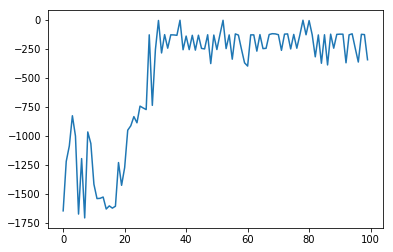

In [25]:
plt.plot(DDPGAgent.total_rewards)

In [29]:

env = wrap_env(gym.make('Pendulum-v0'))

DDPGAgent.run(env)
show_video()


Exception ignored in: <function Monitor.__del__ at 0x00000137DEA9B950>
Traceback (most recent call last):
  File "C:\Users\Z00041331\AppData\Local\Continuum\anaconda3\lib\site-packages\gym\wrappers\monitor.py", line 229, in __del__
    self.close()
  File "C:\Users\Z00041331\AppData\Local\Continuum\anaconda3\lib\site-packages\gym\wrappers\monitor.py", line 140, in close
    self._close_video_recorder()
  File "C:\Users\Z00041331\AppData\Local\Continuum\anaconda3\lib\site-packages\gym\wrappers\monitor.py", line 212, in _close_video_recorder
    self.video_recorder.close()
  File "C:\Users\Z00041331\AppData\Local\Continuum\anaconda3\lib\site-packages\gym\wrappers\monitoring\video_recorder.py", line 129, in close
    os.remove(self.path)
FileNotFoundError: [WinError 2] 系統找不到指定的檔案。: 'D:\\Python\\RL\\video\\openaigym.video.0.2496.video000000.mp4'


DependencyNotInstalled: Found neither the ffmpeg nor avconv executables. On OS X, you can install ffmpeg via `brew install ffmpeg`. On most Ubuntu variants, `sudo apt-get install ffmpeg` should do it. On Ubuntu 14.04, however, you'll need to install avconv with `sudo apt-get install libav-tools`.

In [28]:

env = wrap_env(gym.make('MountainCarContinuous-v0'))

DDPGAgent.run(env)
show_video()


KeyboardInterrupt: 

KeyboardInterrupt: 

KeyboardInterrupt: 

In [42]:
env.action_space.low

array([-1.], dtype=float32)

In [21]:
pd.Series(DDPGAgent.total_rewards).head(50)

0    -34.201
1    -33.428
2    -27.757
3    -36.140
4    -16.635
5    -16.563
6    -16.888
7    -15.801
8    -17.096
9    -15.577
10   -15.581
11   -15.832
12   -16.491
13   -15.755
14   -16.186
15   -17.130
16   -17.628
17   -15.991
18   -16.305
19   -14.705
20   -15.868
21   -16.308
22   -18.002
23   -17.541
24   -17.166
25   -22.535
26   -42.315
27   -54.242
28   -69.813
29   -73.242
30   -71.918
31   -73.805
32   -74.428
33   -74.743
34   -77.023
35   -73.431
36   -74.515
37   -75.870
38   -74.736
39   -77.683
40   -74.382
41   -77.014
42   -74.870
43   -74.914
44   -74.648
45   -76.457
46   -74.760
47   -76.587
48   -75.305
49   -76.362
dtype: float64

In [83]:


class Actor(tf.keras.Model):
    def __init__(self, state_dim, action_dim, max_action, name="Actor"):
        super().__init__(name=name)

        self.l1 = layers.Dense(400, kernel_initializer=PytorchInitializer(),
                               name="L1")
        self.l2 = layers.Dense(300, kernel_initializer=PytorchInitializer(),
                               name="L2")
        self.l3 = layers.Dense(action_dim, kernel_initializer=PytorchInitializer(),
                               name="L3")


        self.max_action = max_action

        # 後段の処理のために早めにshapeを確定させる
        dummy_state = tf.constant(np.zeros(shape=[1, state_dim], dtype=np.float32))
        self(dummy_state)

    def call(self, inputs):
#         with tf.device("/gpu:0"):
        features = tf.nn.relu(self.l1(inputs))
        features = tf.nn.relu(self.l2(features))
        features = self.l3(features)
        action = self.max_action * tf.nn.tanh(features)
        return action


class Critic(tf.keras.Model):
    def __init__(self, state_dim, action_dim, wd=1e-2, name="Critic"):
        super().__init__(name=name)

        self.l1 = layers.Dense(400, kernel_initializer=PytorchInitializer(),
                               kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd),
                               name="L1")
        self.l2 = layers.Dense(300, kernel_initializer=PytorchInitializer(),
                               kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd),
                               name="L2")
        self.l3 = layers.Dense(1, kernel_initializer=PytorchInitializer(),
                               kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd),
                               name="L3")

        dummy_state = tf.constant(np.zeros(shape=[1, state_dim], dtype=np.float32))
        dummy_action = tf.constant(np.zeros(shape=[1, action_dim], dtype=np.float32))
        self([dummy_state, dummy_action])

    def call(self, inputs):
#         with tf.device("/gpu:0"):
        x, u = inputs

        x = tf.nn.relu(self.l1(x))
        inner_feat = tf.concat([x, u], axis=1)
        x = tf.nn.relu(self.l2(inner_feat))
        x = self.l3(x)
        return x


class DDPG(tf.contrib.checkpoint.Checkpointable):
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action)
        self.actor_target = Actor(state_dim, action_dim, max_action)

        # initialize target network
        for param, target_param in zip(self.actor.weights, self.actor_target.weights):
            target_param.assign(param)

        self.actor_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)

        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)

        # initialize target network
        for param, target_param in zip(self.critic.weights, self.critic_target.weights):
            target_param.assign(param)

        self.critic_optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)


    def select_action(self, state):
        """
        :param np.ndarray state:
        :return:
        """
        assert isinstance(state, np.ndarray)
        assert len(state.shape) == 1

        state = np.expand_dims(state, axis=0).astype(np.float32)
        action = self.actor(state).numpy()

        return action[0]

    def train(self, replay_buffer, iterations, batch_size=64, discount=0.99, tau=0.001):

        for it in range(iterations):

            state, next_state, action, reward, done = replay_buffer.sample(batch_size)
            state = np.array(state, dtype=np.float32)
            next_state = np.array(next_state, dtype=np.float32)
            action = np.array(action, dtype=np.float32)
            reward = np.array(reward, dtype=np.float32)
            done = np.array(done, dtype=np.float32)
            not_done = 1 - done

#             with tf.device("/gpu:0"):

            with tf.GradientTape() as tape:
                target_Q = self.critic_target([next_state, self.actor_target(next_state)])
                target_Q = reward + (not_done * discount * target_Q)
                # detach => stop_gradient
                target_Q = tf.stop_gradient(target_Q)

                current_Q = self.critic([state, action])

                # Compute critic loss + L2 loss
                critic_loss = tf.reduce_mean(losses.MSE(current_Q, target_Q)) + 0.5*tf.add_n(self.critic.losses)

            critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
            self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

            with tf.GradientTape() as tape:
                next_action = self.actor(state)
                actor_loss = -tf.reduce_mean(self.critic([state, next_action]))

            actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
            self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))

            # Update target networks
            for param, target_param in zip(self.critic.weights, self.critic_target.weights):
                target_param.assign(tau * param + (1 - tau) * target_param)

            for param, target_param in zip(self.actor.weights, self.actor_target.weights):
                target_param.assign(tau * param + (1 - tau) * target_param)


In [87]:

class DDPG_fast(tf.contrib.checkpoint.Checkpointable):
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action)
        self.actor_target = Actor(state_dim, action_dim, max_action)
        self.actor_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)

        # initialize target network
        for param, target_param in zip(self.actor.weights, self.actor_target.weights):
            target_param.assign(param)

        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        self.critic_optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)

        # initialize target network
        for param, target_param in zip(self.critic.weights, self.critic_target.weights):
            target_param.assign(param)

    def select_action(self, state):
        """
        :param np.ndarray state:
        :return:
        """
        assert isinstance(state, np.ndarray)
        assert len(state.shape) == 1

        state = np.expand_dims(state, axis=0).astype(np.float32)
        action = self._select_action_body(tf.constant(state))

        return action.numpy()[0]

    @tf.contrib.eager.defun
    def _select_action_body(self, state):
        """
        :param np.ndarray state:
        :return:
        """
        action = self.actor(state)
        return action

    def train(self, replay_buffer, iterations, batch_size=64, discount=0.99, tau=0.001):

        for it in range(iterations):

            state, next_state, action, reward, done = replay_buffer.sample(batch_size)
            state = np.array(state, dtype=np.float32)
            next_state = np.array(next_state, dtype=np.float32)
            action = np.array(action, dtype=np.float32)
            reward = np.array(reward, dtype=np.float32)
            done = np.array(done, dtype=np.float32)
            not_done = 1 - done
            self._train_body(state, next_state, action, reward, not_done, discount, tau)

    @tf.contrib.eager.defun
    def _train_body(self, state, next_state, action, reward, not_done, discount, tau):
#         with tf.device("/gpu:0"):

        with tf.GradientTape() as tape:
            target_Q = self.critic_target([next_state, self.actor_target(next_state)])
            target_Q = reward + (not_done * discount * target_Q)
            # detach => stop_gradient
            target_Q = tf.stop_gradient(target_Q)

            current_Q = self.critic([state, action])

            # Compute critic loss + L2 loss
            critic_loss = tf.reduce_mean(losses.MSE(current_Q, target_Q)) + 0.5*tf.add_n(self.critic.losses)

        critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

        with tf.GradientTape() as tape:
            next_action = self.actor(state)
            actor_loss = -tf.reduce_mean(self.critic([state, next_action]))

        actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))

        # Update target networks
        for param, target_param in zip(self.critic.weights, self.critic_target.weights):
            target_param.assign(tau * param + (1 - tau) * target_param)

        for param, target_param in zip(self.actor.weights, self.actor_target.weights):
            target_param.assign(tau * param + (1 - tau) * target_param)

In [88]:
class PytorchInitializer(tf.keras.initializers.Initializer):
    """PytorchのLinearにあわせたinitializer
    stdv = 1. / math.sqrt(self.weight.size(1))
    self.weight.data.uniform_(-stdv, stdv)
    :param seed:
    :return:
    """
    def __init__(self, scale=1.0, seed=None):
        self.seed = seed
        self.scale = scale

    def __call__(self, shape, dtype=None, partition_info=None):
        if dtype is None:
            dtype = tf.float32

        if len(shape) == 1:
            fan_in = shape[0]
        elif len(shape) == 2:
            fan_in = shape[0]
        else:
            raise ValueError("invalid shape")


        scale = self.scale * fan_in

        stdv = 1. / tf.math.sqrt(scale)

        return tf.random_uniform(
            shape, -stdv, stdv, dtype=dtype, seed=self.seed)